<a href="https://colab.research.google.com/github/CardiacModelling/summer-school-2025/blob/main/Hands_on_session_2_action_potential_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-on session 2: action potential models

In this session, we will

- Download a model and prepare it for use in Myokit
- Investigate how the action potential duration changes with pacing rates
- Look at the effects of increasing or reducing current magnitudes.

## Run this first:

In [1]:
# Hide the installation logs:
%%capture
# If installation fails, comment out the line above and run again

# Install Myokit and Sundials
!apt-get install libsundials-dev
!pip install myokit

# Disable debug messages annoyingly shown on colab
import logging
logging.disable(logging.INFO)

# Import myokit and matplotlib
import myokit
import matplotlib.pyplot as plt

## Importing a CellML model

AP models are rarely written "from scratch".
Instead, a typical study will start by either reimplementing a model based on published equations (very laborious!), or by reusing existing code.

To facilitate reuse, the cell electrophysiology community has developed a model exchange format, called [CellML](https://www.cellml.org/), and an online repository, called [PMR](https://models.physiomeproject.org/welcome).
Many cardiac AP models can be found in PMRs "Electrophysiology" section, or through the search function.

Here, we'll download and import the 2008 model of the rabbit ventricular AP by [Mahajan et al.](https://doi.org/10.1529/biophysj.106.98160).

### Obtaining the CellML file

To use this model in Google Colab, either:

1. Download it from [this PMR page](https://models.physiomeproject.org/exposure/a5586b72d07ce03fc40fc98ee846d7a5), then upload it to Colab using the "Files" tab on the left.
2. Download it directly with `wget`, by uncommenting and running one of the lines below:

In [2]:
# Uncomment to download from PMR
#!wget https://models.physiomeproject.org/workspace/mahajan_shiferaw_sato_baher_olcese_xie_yang_chen_restrepo_karma_garfinkel_qu_weiss_2008/download/e86beea89021fd242713459a5c4b5ea2ba33a445/mahajan_shiferaw_sato_baher_olcese_xie_yang_chen_restrepo_karma_garfinkel_qu_weiss_2008.cellml

In [3]:
# Uncomment to download from GitHub
!wget https://raw.githubusercontent.com/CardiacModelling/summer-school-2025/refs/heads/main/resources/mahajan_shiferaw_sato_baher_olcese_xie_yang_chen_restrepo_karma_garfinkel_qu_weiss_2008.cellml

--2025-10-05 13:51:13--  https://raw.githubusercontent.com/CardiacModelling/summer-school-2025/refs/heads/main/resources/mahajan_shiferaw_sato_baher_olcese_xie_yang_chen_restrepo_karma_garfinkel_qu_weiss_2008.cellml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147472 (144K) [text/plain]
Saving to: ‘mahajan_shiferaw_sato_baher_olcese_xie_yang_chen_restrepo_karma_garfinkel_qu_weiss_2008.cellml.3’

mahajan_shiferaw_sa 100%[===================>] 144.02K  --.-KB/s    in 0.02s   

2025-10-05 13:51:14 (6.61 MB/s) - ‘mahajan_shiferaw_sato_baher_olcese_xie_yang_chen_restrepo_karma_garfinkel_qu_weiss_2008.cellml.3’ saved [147472/147472]



### Importing the model in Myokit

To use the model in Myokit, we'll load the module [`myokit.formats`](https://myokit.readthedocs.io/en/stable/api_formats/index.html) and create a `CellMLImporter`

In [4]:
# Create a CellML importer
import myokit.formats
importer = myokit.formats.importer('cellml')

# Import the model
model = importer.model('mahajan_shiferaw_sato_baher_olcese_xie_yang_chen_restrepo_karma_garfinkel_qu_weiss_2008.cellml')

print(f'Imported model {model.name()}')

Imported model mahajan_2008


To see what we've imported, we can print the model's equations:

In [5]:
print(model.code())

[[model]]
author: Myokit CellML 1 API
documentation: """
    Model Status
    
    This model is known to run in OpenCell and COR to reproduce the output
    shown in the publication. The units have been checked and they are
    consistent.
    
    Model Structure
    
    ABSTRACT: Mathematical modeling of the cardiac action potential has proven
    to be a powerful tool for illuminating various aspects of cardiac function,
    including cardiac arrhythmias. However, no currently available detailed
    action potential model accurately reproduces the dynamics of the cardiac
    action potential and intracellular calcium (Ca(i)) cycling at rapid heart
    rates relevant to ventricular tachycardia and fibrillation. The aim of this
    study was to develop such a model. Using an existing rabbit ventricular
    action potential model, we modified the L-type calcium (Ca) current
    (I(Ca,L)) and Ca(i) cycling formulations based on new experimental patch-
    clamp data obtained in isolat

Near the very bottom, we spot a component named `cell` that contains a state variable `cell.V` in units of `mV`.

This has a defining equation of the form
\begin{align}
\frac{dV}{dt} = - \frac{1}{C} \sum{I}
\end{align}
(note that the division by C isn't written explicitly here, but introduced by writing all the currents in units of pA/pF).

It's safe to say, we've found the variable representing the membrane potential.

## Extracting a pacing protocol

Now we have a model, but no pacing protocol.
In most CellML models, this is hardcoded into the equations.
Above, we can spot this in the `cell` component, which defines a stimulus current `i_Stim` with a period of 400ms and a duration of 3ms.

Using this information, we can manually rewrite the model to remove this hardcoded stimulus and add in an entry point for a pacing protocol.
However, in many cases we can do this automatically using the module `myokit.lib.guess`:

In [12]:
# Extract the protocol from the model, and update the model code
protocol = myokit.lib.guess.remove_embedded_protocol(model)

print(protocol)

[[protocol]]
# Level  Start    Length   Period   Multiplier
1.0      0.0      3.0      400.0    0


We can see the changes made to the model by printing the code for the `cell` component:

In [13]:
print(model.get('cell').code())

[cell]
Itotal = -(INa.xina + IK1.xik1 + IKr.xikr + IKs.xiks + Ito.xito + INaCa.xiNaCa + ICaL.xica + INaK.xiNaK + i_Stim)
    in [A/F]
dot(V) = Itotal
    in [mV]
i_Stim = pace * stim_amplitude
    in [A/F]
pace = 0 bind pace
    in [1]
past = floor(Environment.time / stim_period) * stim_period
    in [ms]
stim_amplitude = -15 [A/F]
    in [A/F]
stim_period = 400 [ms]
    in [ms]
wca = 8 [g*m^5/s^3/A/mol (1000)]
    in [g*m^5/s^3/A/mol (1000)]




Above, we can see the protocol has been correctly converted.

In the model, `i_Stim` is now defined as `pace * stim_amplitude`, where `pace` will be set by the simulation engine - this is indicated through the `bind` keyword, which we won't cover further here.
The variable `stim_period` is still present, but is no longer used.

Using the updated model and extracted protocol, we can now run simulations:

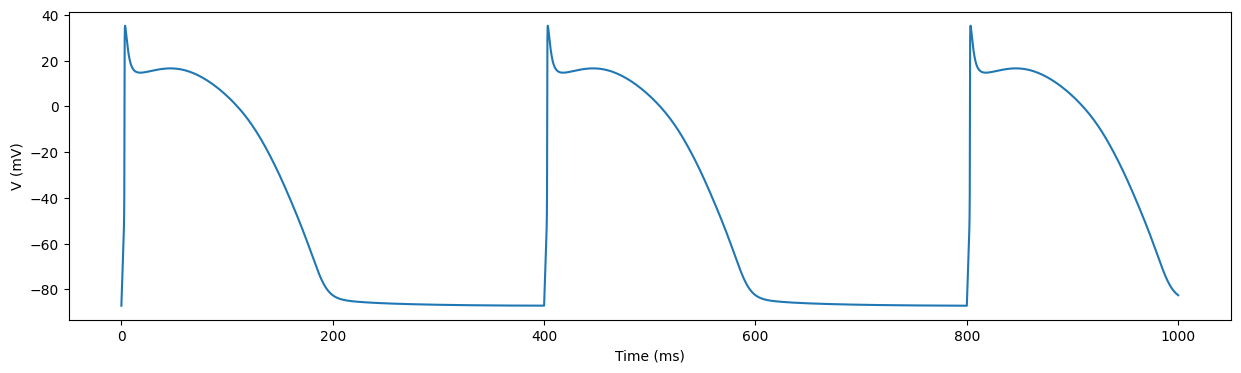

In [14]:
sim = myokit.Simulation(model, protocol)
log = sim.run(1000)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot()
ax.set_xlabel('Time (ms)')
ax.set_ylabel('V (mV)')
ax.plot(log.time(), log['cell.V'])
plt.show()

### Further reading: Other model sources

Not all models make it into PMR.
By one estimate (based on the list below), around 40% of cardiac AP models are listed, with older models more likely to be included.

Increasingly, authors do provide their original code, a supplements to publications, on lab websites, or in (GitHub) repositories.
A long list of AP models with links to known implementations is maintained at https://github.com/myokit/model-list.
To use these models in Myokit, it is necessary to manually translate the code.

## Changing the pacing rate

Next, we'll experiment with changing the pacing rate.
To do this, we could manually specify a new protocol:

In [15]:
protocol = myokit.parse_protocol('''
  [[protocol]]
  # Level  Start    Length   Period   Multiplier
  1.0      0.0      3.0      600.0    0
  ''')

But it's easier to use the [blocktrain](https://myokit.readthedocs.io/en/stable/api_simulations/Protocol.html#myokit.pacing.blocktrain) method:

In [16]:
period = 600
protocol = myokit.pacing.blocktrain(period=period, duration=3)

✏️ Below, create a simulation using a new protocol with a period of 300ms, and simulate at least 5 APs.

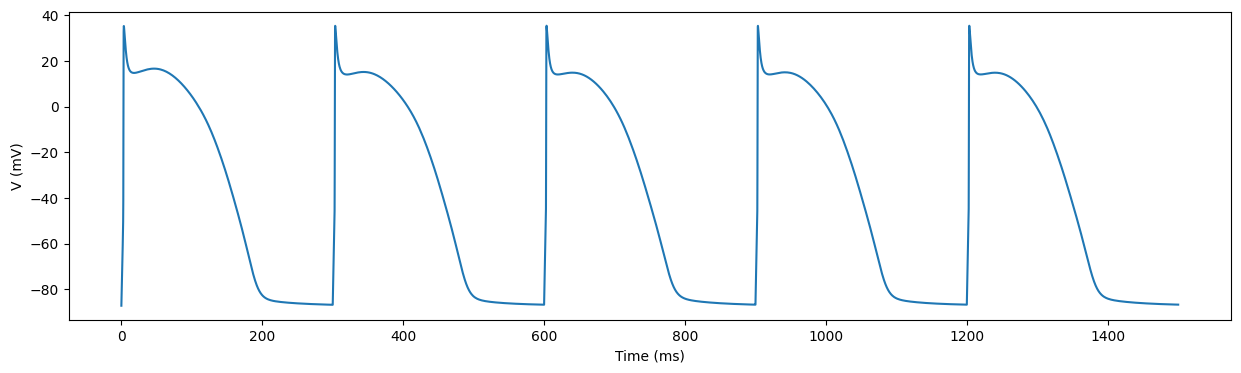

In [17]:
period = 300
protocol = myokit.pacing.blocktrain(period=period, duration=3)
sim = myokit.Simulation(model, protocol)
log = sim.run(5 * period)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot()
ax.set_xlabel('Time (ms)')
ax.set_ylabel('V (mV)')
ax.plot(log.time(), log['cell.V'])
plt.show()

Looking at the shape of the APs, you should notice

1. A change in the shape from the 1st to the 5th AP, particularly in the plateau phase
2. A gradual reduction in the action potential duration (APD).

Biologically, this is highly desirable behaviour: the cell is adapting to the new pacing rate!

✏️ Make the changes more clear by creating a plot overlaying the 1st and 5th APs.

💡 Manipulating times is easier with `numpy`. You can use `log = log.npview()` to convert all logged data to numpy.

💡 It's even less work to use the Myokit method [log.split_periodic()](https://myokit.readthedocs.io/en/stable/api_simulations/DataLog.html#myokit.DataLog.split_periodic)

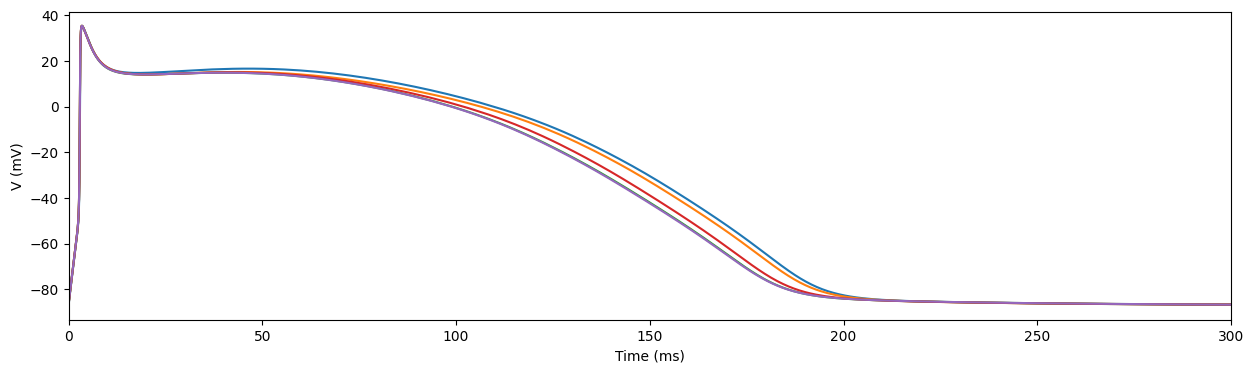

In [18]:
log = log.npview()

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot()
for offset in range(5):
  ax.plot(log.time() - offset * period, log['cell.V'])
ax.set_xlabel('Time (ms)')
ax.set_ylabel('V (mV)')
ax.set_xlim(0, 300)
plt.show()

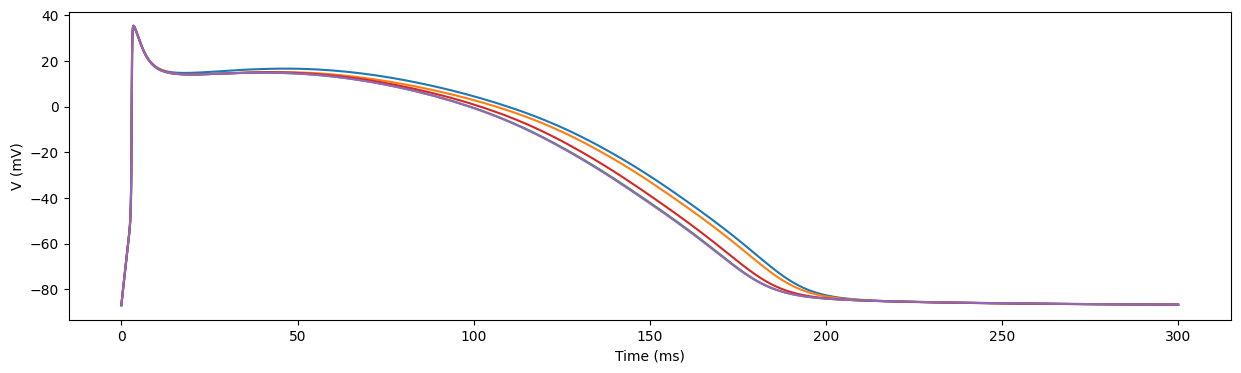

In [19]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot()
for part in log.split_periodic(period, adjust=True):
  ax.plot(part.time(), part['cell.V'])
ax.set_xlabel('Time (ms)')
ax.set_ylabel('V (mV)')
plt.show()

✏️ Create a new simulation with a pacing period of 190ms and simulate 10 APs. What happens during the first AP?

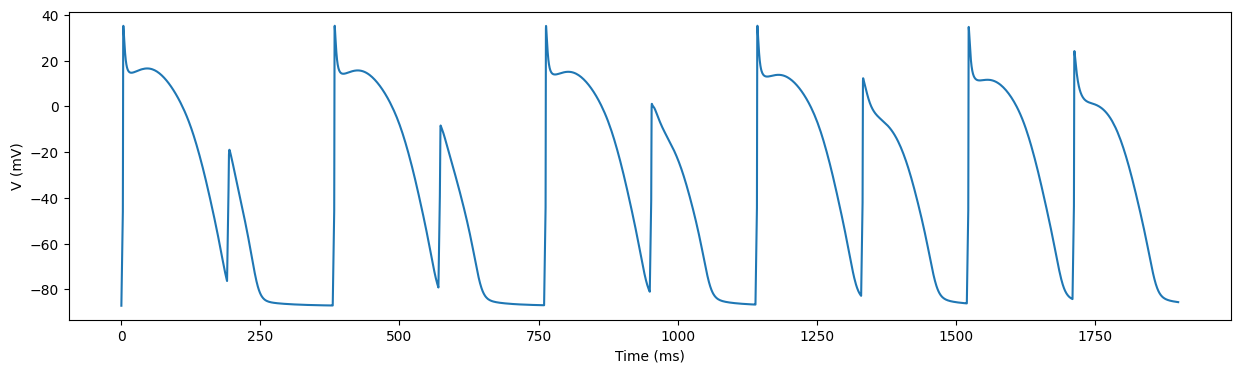

In [20]:
period = 190
protocol = myokit.pacing.blocktrain(period=period, duration=3)
sim = myokit.Simulation(model, protocol)
log = sim.run(10 * period)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot()
ax.plot(log.time(), log['cell.V'])
ax.set_xlabel('Time (ms)')
ax.set_ylabel('V (mV)')
plt.show()

✏️ The speed at which the model adapts is dictated by the most slowly changing state variables. In AP models, these are usually internal ion concentrations (e.g. Na+, K+, Cl-, and most importantly Ca2+). Two important concentration variables in this model are `Na.Na_i` and `Ca.Ca_i`, representing the Na+ and Ca2+ concentrations in the cytoplasm. Using the `log` from the simulation above, plot their evolution over time:

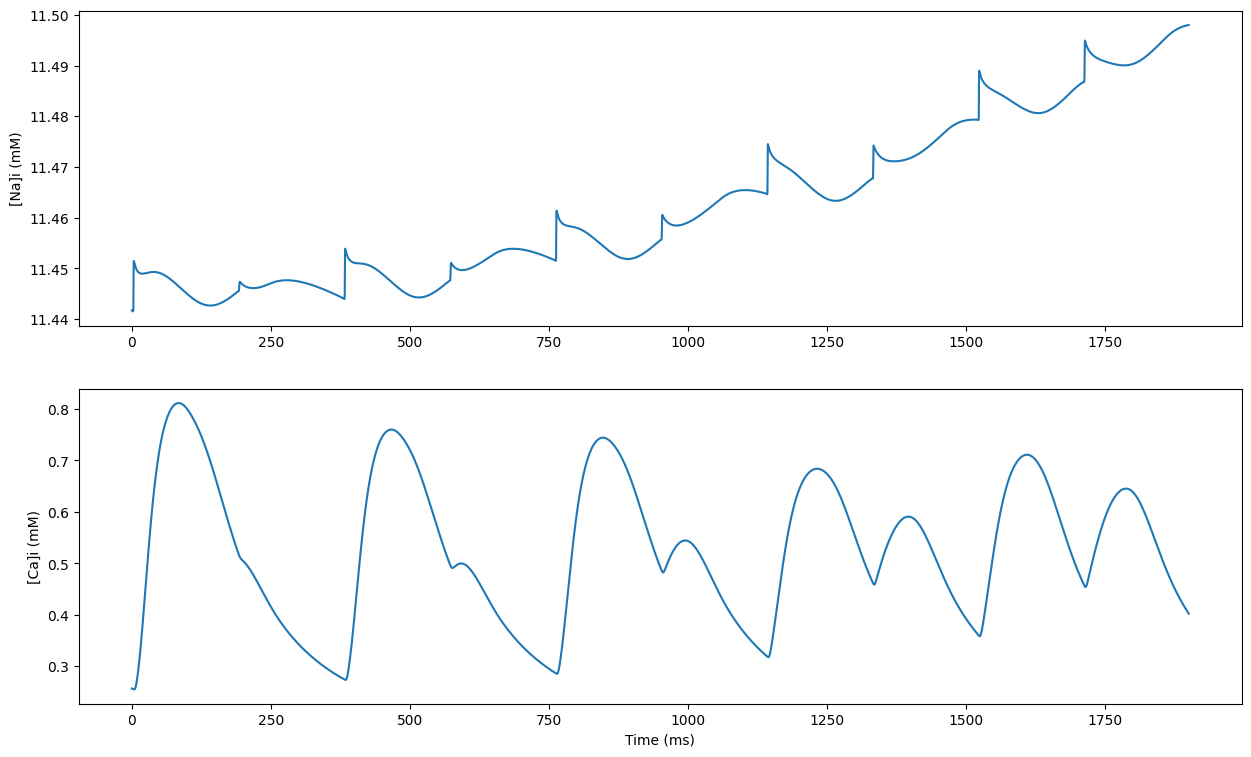

In [21]:
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(2, 1, 1)
ax.plot(log.time(), log['Na.Na_i'])
ax.set_ylabel('[Na]i (mM)')
ax = fig.add_subplot(2, 1, 2)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('[Ca]i (mM)')
ax.plot(log.time(), log['Ca.Ca_i'])
plt.show()

## Pacing to "steady state"

Simulation experiments often start by ensuring the cell has settled into a stable rhythm, and is not adapting to any changes we made (or badly chosen initial conditions).

In mathematical terms, we need to wait for the system to reach a _periodic orbit_.
But in AP modeller's jargon this is (incorrectly) called _reaching a steady state_.

To test if we're in a "steady state", we're going to plot the cytosolic sodium and calcium concentrations again, but with two changes that improve performance:

1. We'll only log the variables we need by setting the `log` argument in our call to `run`.
2. We'll only log _one point per period_, by setting a `log_interval`.


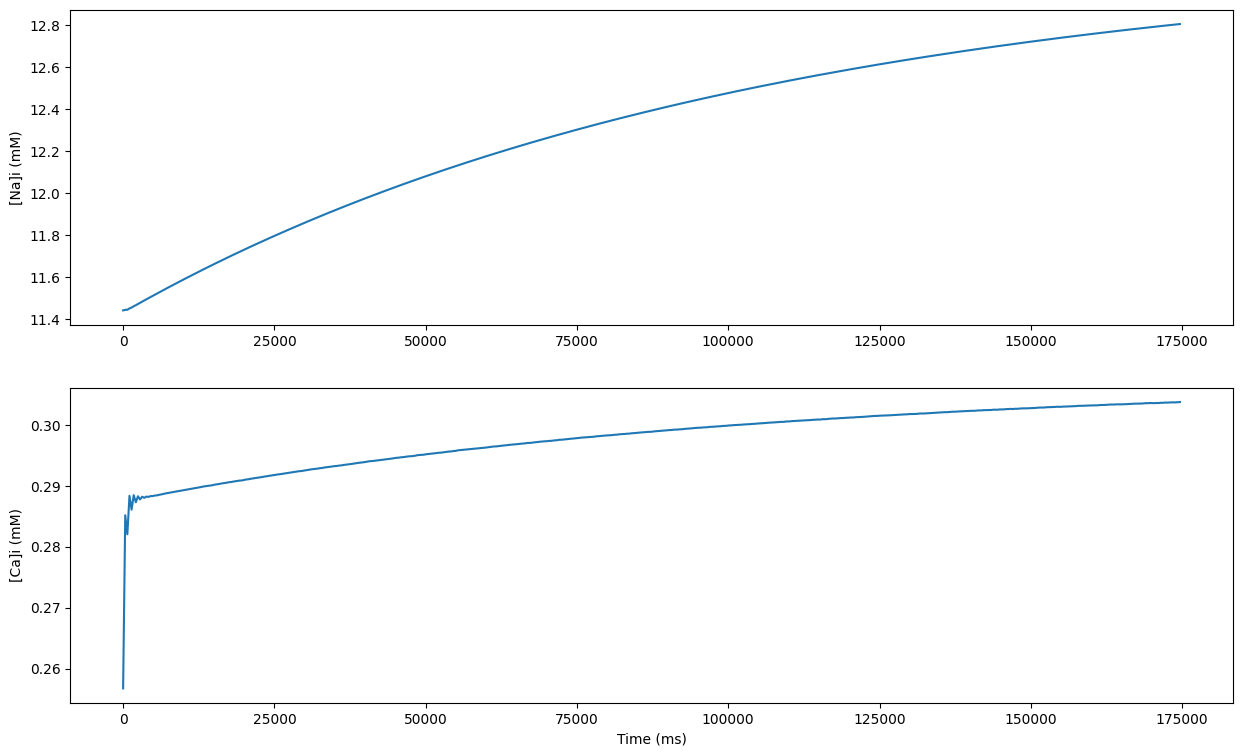

In [22]:
period = 350
protocol = myokit.pacing.blocktrain(period=period, duration=3)
sim = myokit.Simulation(model, protocol)
log = sim.run(500 * period, log=['Environment.time', 'Ca.Ca_i', 'Na.Na_i'], log_interval=period)

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(2, 1, 1)
ax.set_ylabel('[Na]i (mM)')
ax.plot(log.time(), log['Na.Na_i'])
ax = fig.add_subplot(2, 1, 2)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('[Ca]i (mM)')
ax.plot(log.time(), log['Ca.Ca_i'])
plt.show()


This shows that, even for a modest change in pacing rate, adaptation (in this model) takes hundreds of beats.

✏️ So far, we have assumed that the model was in a "steady state" when we first loaded it. This is a dangerous assumption! Repeat the above experiment to check.

💡 Hint 1: After running once, repeat with higher precision by calling `sim.set_tolerance(1e-8, 1e-8)`.

💡 Hint 2: When reading the final values on the plots, make sure to check the top-left part of the plot, where matplotlib sometimes places an "offset". The values on the y-axis should all be read as "value" + "offset".

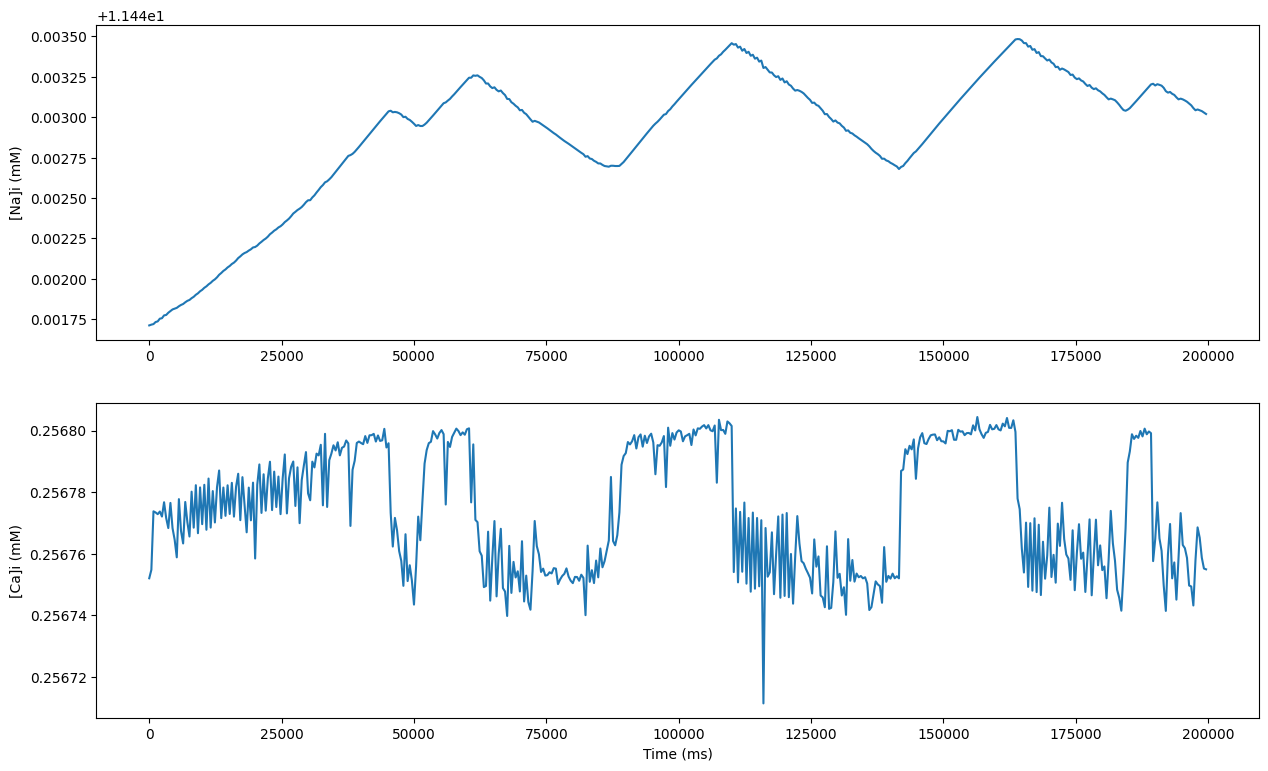

In [23]:
period = 400
protocol = myokit.pacing.blocktrain(period=period, duration=3)
sim = myokit.Simulation(model, protocol)
log = sim.run(500 * period, log=['Environment.time', 'Ca.Ca_i', 'Na.Na_i'], log_interval=period)

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(2, 1, 1)
ax.plot(log.time(), log['Na.Na_i'])
ax.set_ylabel('[Na]i (mM)')
ax = fig.add_subplot(2, 1, 2)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('[Ca]i (mM)')
ax.plot(log.time(), log['Ca.Ca_i'])
plt.show()


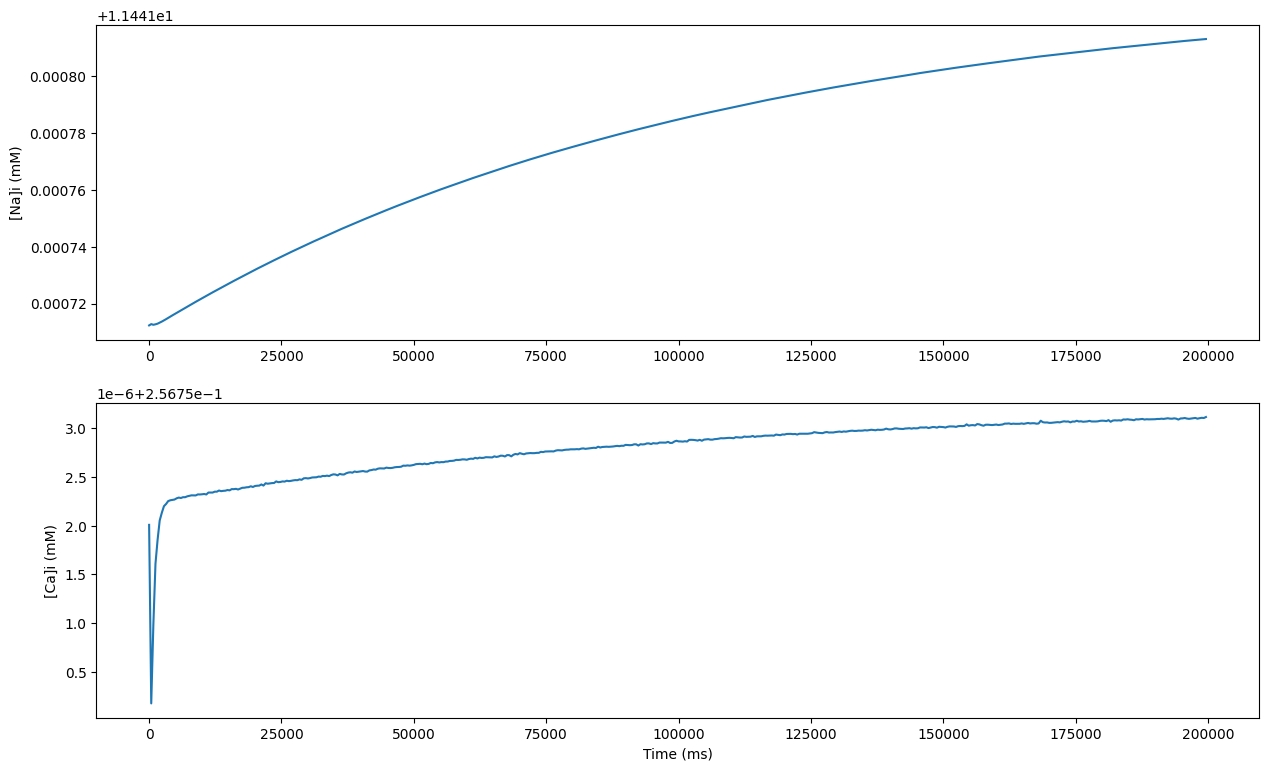

In [24]:
period = 400
protocol = myokit.pacing.blocktrain(period=period, duration=3)
sim = myokit.Simulation(model, protocol)
sim.set_tolerance(1e-8, 1e-8)
log = sim.run(500 * period, log=['Environment.time', 'Ca.Ca_i', 'Na.Na_i'], log_interval=period)

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(2, 1, 1)
ax.plot(log.time(), log['Na.Na_i'])
ax.set_ylabel('[Na]i (mM)')
ax = fig.add_subplot(2, 1, 2)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('[Ca]i (mM)')
ax.plot(log.time(), log['Ca.Ca_i'])
plt.show()


**Note**: The long simulation time needed to bring a cell model into "steady state" is one of the reasons that whole-heart simulations typically avoid models with variable internal concentrations.

## Calculating action potential durations

Now, let's quantify the changes to the AP we saw, by measuring the action potential duration (APD).

To do this, we'll first need to define what an "AP" is.
This can get quite complicated, but for now, we'll stick with the common definition of "any depolarisation above 10% of the voltage range", i.e. the APD90.

We'll start by running a quick simulation to find the lower and upper bounds of the voltage range.

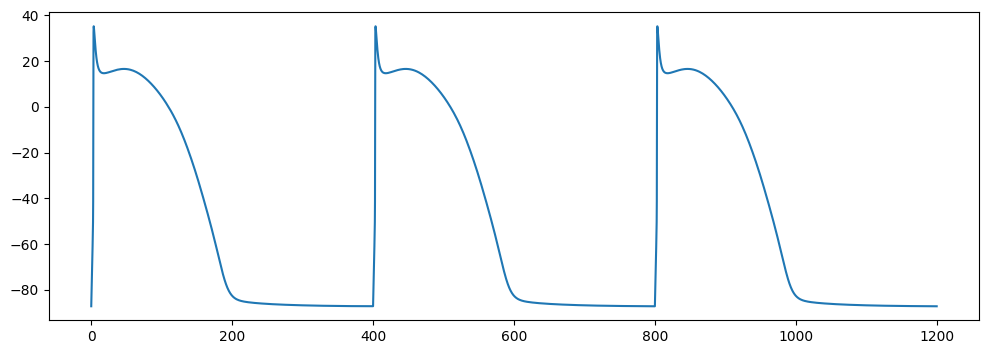

In [25]:
period = 400
protocol = myokit.pacing.blocktrain(period=period, duration=3)
sim = myokit.Simulation(model, protocol)
log = sim.run(3 * period)

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot()
ax.plot(log.time(), log['cell.V'])
plt.show()

Now we can get the minimum and maximum voltages using `min` and `max`:

In [26]:
Vmin = min(log['cell.V'])
Vmax = max(log['cell.V'])
print(Vmin, Vmax)

-87.17457091130206 35.26923655616175


In [27]:
V90 = Vmin + 0.1 * (Vmax - Vmin)
print('Threshold:', V90)

Threshold: -74.93019016455567


Using this threshold, we run another simulation, but this time with APD measurement enabled.
We can do this by passing in a `apd_variable` and `apd_threshold` to the `run` method:

In [28]:
period = 400
protocol = myokit.pacing.blocktrain(period=period, duration=3)
sim = myokit.Simulation(model, protocol)
log, apds = sim.run(3 * period, apd_variable='cell.V', apd_threshold=V90)

print(apds)

DataLog({'start': [0.8668406700535571, 400.86715901223533, 800.8671443626583], 'duration': [187.70695482523573, 187.74186429275676, 187.73357737657068]})


Note how this changes the return type of the [run](https://myokit.readthedocs.io/en/stable/api_simulations/Simulation.html#myokit.Simulation.run) method: It now returns _two_ DataLogs, where the second has the entries `start` and `duration` containing the start times and durations of all detected APs.

✏️ Change the pacing frequency to 350ms, and plot APD during the first 1000 beats.

💡 You can speed up the simulation significantly by disabling logging. To do this, add `log=myokit.LOG_NONE` to the run method's arguments.

💡 For the plot's x-axis, you can use `range(len(apds['duration']))` to create a list of the numbers [0, 1, 2, ...] up to the number of APs.

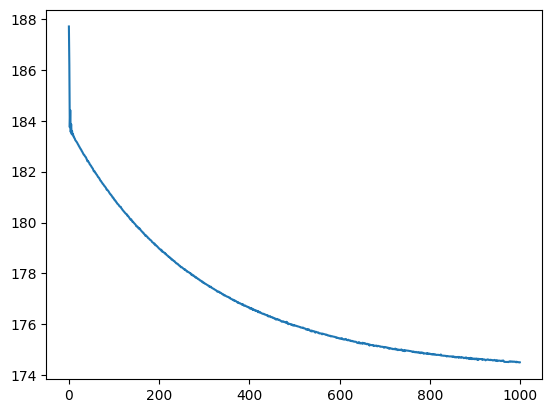

In [29]:
period = 350
protocol = myokit.pacing.blocktrain(period=period, duration=3)
sim = myokit.Simulation(model, protocol)
log, apds = sim.run(1000 * period, log=myokit.LOG_NONE, apd_variable='cell.V', apd_threshold=V90)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(range(len(apds['duration'])), apds['duration'])
plt.show()

✏️ Repeat this exercise with a period of 200ms. What do you observe?

💡 If the plot looks strange, try zooming in on the final 10 APs with `ax.set_xlim(990, 1000)`.

In [30]:
period = 200
protocol = myokit.pacing.blocktrain(period=period, duration=3)
sim = myokit.Simulation(model, protocol)
log, apds = sim.run(1000 * period, log=myokit.LOG_NONE, apd_variable='cell.V', apd_threshold=V90)

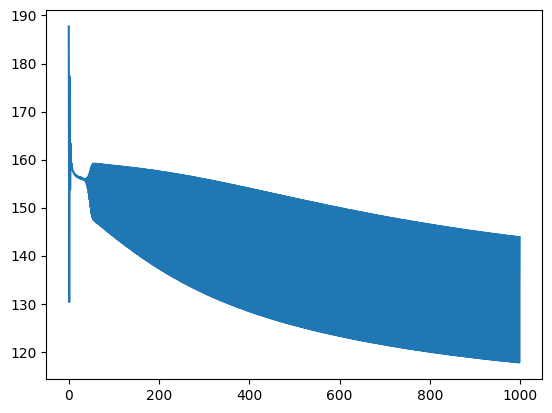

In [31]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(range(len(apds['duration'])), apds['duration'])
plt.show()

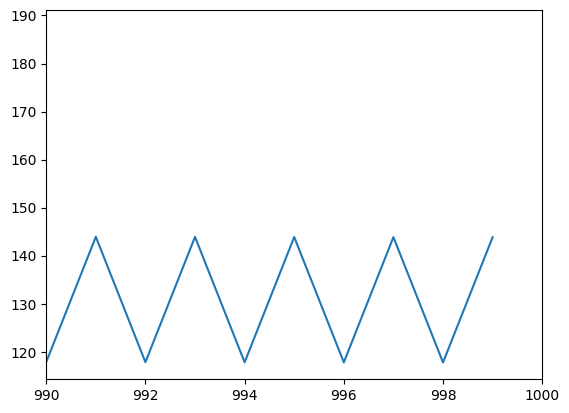

In [32]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(range(len(apds['duration'])), apds['duration'])
ax.set_xlim(990, 1000)
plt.show()

At this rate, the system doesn't settle into a periodic orbit of 200ms.
Instead, the APD alternates between two stable values: it might still be periodic, but the period has doubled to 400ms!

In cell electrophysiology, this is known as _alternans_ and is of particular interest because of its [association with reentrant arrhythmias](https://www.ahajournals.org/doi/10.1161/JAHA.119.013750).

## Restitution

> Cardiac restitution is the ability of the heart to recover from one beat to the next. At its simplest, it is the relationship of how long the heart is in contraction compared to how much rest it has between beats to permit recovery.

[Fossa, 2017](https://onlinelibrary.wiley.com/doi/epdf/10.1111/anec.12460).

At the _cell level_, the term _restitution_ is used to refer to the relationship between the action potential duration (APD) and diastolic interval (DI).
A common way to visualise this, is to plot the APD as a function of the DI.

✏️ Plot the restitution curve for the Mahajan et al. model, using the periods `[300, 280, 260, 240, 220, 210, 205, 200, 195, 190]`. To get closer to steady state, run for at least 100 beats at each period.

💡 Make sure you log at least 2 APDs at each period, in case of alternans

💡 To improve performance, disable logging with `log=myokit.LOG_NONE`

💡 You can reuse the same simulation for each period, by changing the protocol with `sim.set_protocol()` and resetting time to 0 with `sim.set_time(0)`

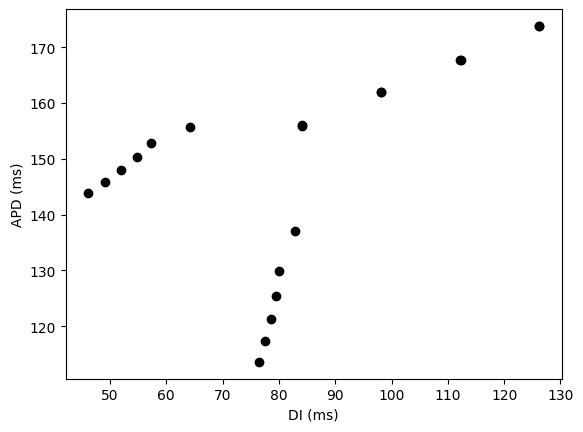

In [33]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlabel('DI (ms)')
ax.set_ylabel('APD (ms)')

sim = myokit.Simulation(model, protocol)
for period in [300, 280, 260, 240, 220, 210, 205, 200, 195, 190]:
  sim.set_protocol(myokit.pacing.blocktrain(period=period, duration=3))
  sim.set_time(0)
  sim.run(100 * period, log=myokit.LOG_NONE)
  log, apds = sim.run(2 * period, apd_variable='cell.V', apd_threshold=V90)
  y = apds['duration']
  x = [period - y[0], period - y[1]]
  ax.plot(x, y, 'ko')
plt.show()


## Upsetting the balance in the plateau

During the plateau phase of the AP, the inward current ICaL is balanced by outward potassium currents.
In humans, the strongest potassium current is IKr, but in this rabbit model IKs is dominant.
The size of these currents is determined by model variables `ICaL.gca = 182 [mmol/cm/C]` and `IKs.gks = 0.1386 [mS/uF]`.

✏️ Show the effect of reducing or increasing ICaL and IKs on the AP, by changing the `gca` and `gks` values using [`sim.set_constant'](https://myokit.readthedocs.io/en/stable/api_simulations/Simulation.html#myokit.Simulation.set_constant).

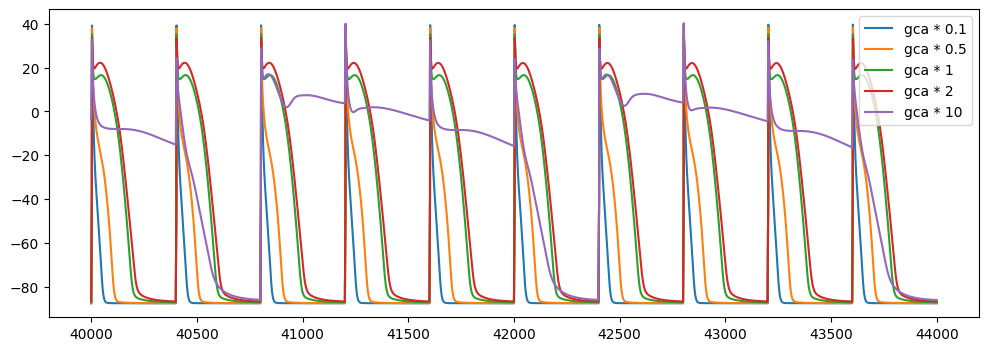

In [34]:
period = 400
protocol = myokit.pacing.blocktrain(period=period, duration=3)
sim = myokit.Simulation(model, protocol)

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot()
for f in [0.1, 0.5, 1, 2, 10]:
  sim.reset()
  sim.set_constant('ICaL.gca', f * 182)
  sim.run(100 * period, log=myokit.LOG_NONE)
  log = sim.run(10 * period)
  ax.plot(log.time(), log['cell.V'], label=f'gca * {f}')
ax.legend()
plt.show()

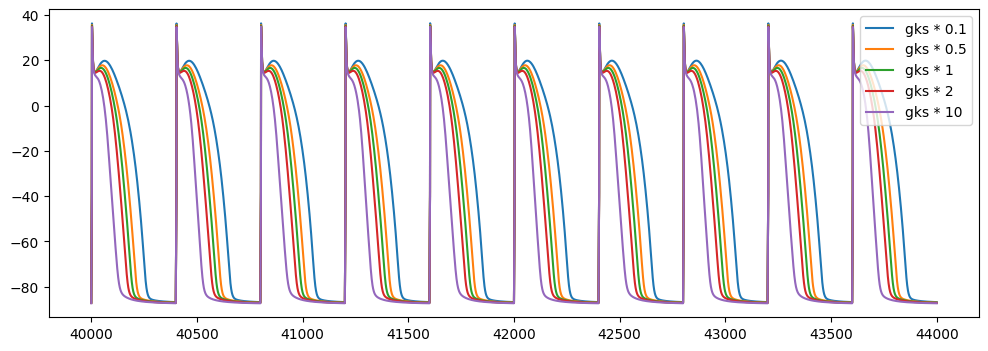

In [35]:
period = 400
protocol = myokit.pacing.blocktrain(period=period, duration=3)
sim = myokit.Simulation(model, protocol)

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot()
for f in [0.1, 0.5, 1, 2, 10]:
  sim.reset()
  sim.set_constant('IKs.gks', f * 0.1386)
  sim.run(100 * period, log=myokit.LOG_NONE)
  log = sim.run(10 * period)
  ax.plot(log.time(), log['cell.V'], label=f'gks * {f}')
ax.legend()
plt.show()

✏️ Show the effect of changing ICaL or IKs size on the restitution curve.

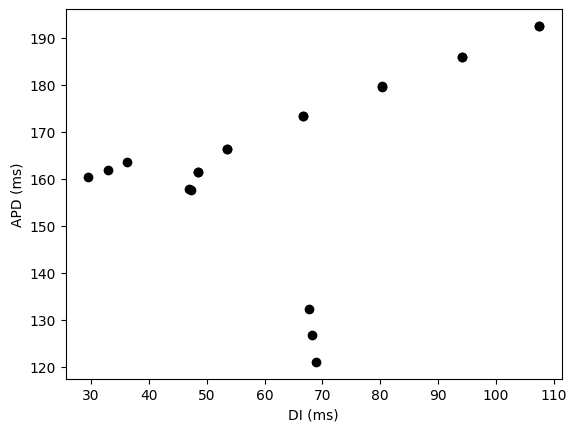

In [36]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlabel('DI (ms)')
ax.set_ylabel('APD (ms)')

sim = myokit.Simulation(model, protocol)
sim.set_constant('IKs.gks', 0.5 * 0.1386)
for period in [300, 280, 260, 240, 220, 210, 205, 200, 195, 190]:
  sim.set_protocol(myokit.pacing.blocktrain(period=period, duration=3))
  sim.set_time(0)
  sim.run(100 * period, log=myokit.LOG_NONE)
  log, apds = sim.run(2 * period, apd_variable='cell.V', apd_threshold=V90)
  y = apds['duration']
  x = [period - y[0], period - y[1]]
  ax.plot(x, y, 'ko')
plt.show()
